In [42]:
#pip install xverse

In [86]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [43]:
import pandas as pd
import numpy as np
import os
import glob 
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from xverse.transformer import WOE
from xverse.transformer import MonotonicBinning
from xverse.ensemble import VotingSelector


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




In [44]:
## Funciones Personalizadas

##-------------------------------------------------------------------------------##

## Funciones para valores perdidos.

## Porcentaje de valores perdidos por variable
def resum_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje'])
    return missing_data

## dataFrame de resumen de posición de valores perdidos. 
    
def posmissing(df):
    lista_miss = np.where(df.isna())
    v1 = pd.Series(np.ndarray.tolist(lista_miss[0]))
    v2 = pd.Series(np.ndarray.tolist(lista_miss[1]))
    resumen_vna = pd.concat([v1, v2], axis=1, keys=['posicion_fila', 'posicion_columna'])
    return resumen_vna

In [45]:
# 1. Lee los nombres de archivos del directorio de 
#    trabajo
filenames = glob.glob('Datos/*.csv')

In [46]:
filenames

['Datos\\DatosNegativos1.csv', 'Datos\\DatosPositivos1.csv']

In [47]:
# 2. lee el contenido de los archivos .xlsx
df = pd.DataFrame()
for filename in filenames:
    data = pd.read_csv(filename)
    print(data.shape)
    df = df.append(data)

(5561, 1760)
(8322, 1761)


In [48]:
df.shape

(13883, 1761)

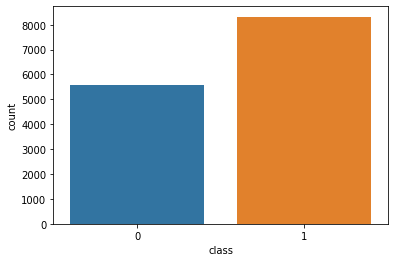

In [49]:
# Contamos los valores por clase, y vemos que la clase está balanceada
sns.countplot(df["class"])

In [50]:
# Eliminamos la columna que ennumera del primer archivo
df_dep = df.drop(columns="Unnamed: 0")

In [51]:
df_dep.head()

,A,AA,AC,AD,AE,AF,AG,AH,AI,AK,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
0,28.571,16.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.979,0.0,1.895,0.994,0.781,0.0,0.0,0.0
1,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.769,0.0,2.119,0.028,1.000,0.0,0.0,0.0
2,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.844,0.0,0.977,0.096,0.138,0.0,0.0,0.0
3,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.564,0.0,0.504,0.096,0.095,0.0,0.0,0.0
4,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.813,0.0,0.980,0.848,0.065,0.0,0.0,0.0


In [52]:
# Creamos una columna enumerando cada fila
df_dep = df_dep.assign(num=[0 + i for i in range(len(df_dep))])[['num'] + df_dep.columns.tolist()]

In [53]:
df_dep.tail()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
8317,13878,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,3.404,0.0,2.520,3.511,3.691,2.329,0.240,1.653
8318,13879,33.333,0.0,0.0,0.0,0.0,0.0,12.50,0.0,0.0,...,0.0,0.0,1.537,0.0,0.941,1.213,1.282,1.165,0.048,0.000
8319,13880,6.667,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,6.170,0.0,4.833,6.313,5.053,2.881,4.180,2.857
8320,13881,5.556,0.0,0.0,0.0,0.0,0.0,5.88,0.0,0.0,...,0.0,0.0,3.430,0.0,6.001,5.297,4.848,4.387,3.797,3.346
8321,13882,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,7.002,0.0,3.670,12.909,11.567,1.463,6.780,12.438


In [54]:
# Guardamos la variables sequence
df_1 = df_dep[["num", "sequence"]]
df_1.tail()

,num,sequence
8317,13878,ILPIIGKILSTIFGK
8318,13879,YAGAVANDL
8319,13880,KKCFRWQWRMKKLGA
8320,13881,GWAGWLLSPRGSRPSWGP
8321,13882,LRRLYKRVVKLWKRLFRQLRRPVR


In [55]:
# Eliminamos la variable sequence del dataframe depurado
df_dep.pop("sequence")
df_dep.head()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
0,0,28.571,16.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.979,0.0,1.895,0.994,0.781,0.0,0.0,0.0
1,1,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.769,0.0,2.119,0.028,1.000,0.0,0.0,0.0
2,2,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.844,0.0,0.977,0.096,0.138,0.0,0.0,0.0
3,3,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.564,0.0,0.504,0.096,0.095,0.0,0.0,0.0
4,4,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.813,0.0,0.980,0.848,0.065,0.0,0.0,0.0


In [56]:
# Revisamos valores nulos
resum_missing(df_dep).head(10)

,Total,Porcentaje
tausw9,0,0.0
MoranAuto_Mutability8,0,0.0
MoranAuto_Mutability25,0,0.0
MoranAuto_Mutability26,0,0.0
MoranAuto_Mutability27,0,0.0
MoranAuto_Mutability28,0,0.0
MoranAuto_Mutability29,0,0.0
MoranAuto_Mutability3,0,0.0
MoranAuto_Mutability30,0,0.0
MoranAuto_Mutability4,0,0.0


In [57]:
# Asignamos la variable objetivo
y = df_dep.pop("class")

## 1- Clasificación sin selección

### 1.1 Normalización

In [58]:
# Normalizamos el set de datos
names = df_dep.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df_dep)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [59]:
scaled_df.tail()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
13878,1.730928,-0.863028,-0.296462,-0.14897,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,-0.692274,-0.245378,-0.819084,-0.523872,-0.336594,-0.585010,-1.236946,-0.681558
13879,1.731177,3.158718,-0.296462,-0.14897,-0.168532,-0.179553,-0.205495,6.237163,-0.145561,-0.255284,...,-0.306448,-0.281046,-1.318133,-0.245378,-1.370418,-1.253591,-1.115106,-0.997318,-1.304774,-1.237456
13880,1.731427,-0.058630,-0.296462,-0.14897,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,0.234950,-0.245378,-0.011461,0.365889,0.103561,-0.389483,0.154951,-0.276657
13881,1.731677,-0.192676,-0.296462,-0.14897,-0.168532,-0.179553,-0.205495,2.781368,-0.145561,-0.255284,...,-0.306448,-0.281046,-0.683558,-0.245378,0.396366,0.043263,0.037312,0.143967,0.019648,-0.112208
13882,1.731926,-0.863028,-0.296462,-0.14897,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,0.513854,-0.245378,-0.417542,2.460417,2.208679,-0.891761,1.073462,2.945398


In [60]:
y

0       0
1       0
2       0
3       0
4       0
       ..
8317    1
8318    1
8319    1
8320    1
8321    1
Name: class, Length: 13883, dtype: int64

### 1.2 Creación de particiones

In [62]:
# 3. Particionamos el set de datos
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size = .2, random_state=42, stratify = y)

### 1.3 Balanceamos el set de datos

In [63]:
# Se balancean los datos
sm = SMOTE(random_state=42)
sm_data_X,sm_data_y=sm.fit_sample(X_train, y_train)

In [64]:
## Convirtiendo en DataFrame
bal_data_X = pd.DataFrame(sm_data_X, columns=X_train.columns)
type(bal_data_X)

pandas.core.frame.DataFrame

In [65]:
bal_data_y = pd.Series(sm_data_y)
type(bal_data_y)

pandas.core.series.Series

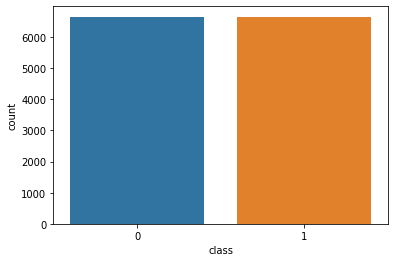

In [66]:
# Revisamos las clases
sns.countplot(bal_data_y)

In [67]:
type(sm_data_X)

pandas.core.frame.DataFrame

In [68]:
type(sm_data_y)

pandas.core.series.Series

### 1.3.1 Random Forest

In [69]:
# Entrenamos un modelo con Random Forest 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 5, max_depth=5, random_state=0)
clf.fit(bal_data_X, bal_data_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [70]:
# Aplicamos validación cruzada para evaluar el performance del modelo
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(clf, bal_data_X, bal_data_y, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.02)


In [71]:
# Hacemos predicciones con la data de prueba
predict = clf.predict(X_test)

In [72]:
predict

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [73]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[ 983,  129],
       [ 265, 1400]], dtype=int64)

In [74]:
# Revisamos otras metricas del modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.79      0.88      0.83      1112
           1       0.92      0.84      0.88      1665

    accuracy                           0.86      2777
   macro avg       0.85      0.86      0.85      2777
weighted avg       0.86      0.86      0.86      2777



### 1.3.2 Redes Neuronales

In [122]:
model = keras.Sequential([
    #keras.layers.Dense(len(bal_data_X.columns), activation=tf.nn.relu, input_shape=[len(bal_data_X.columns)]),
    #keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(len(bal_data_X.columns), activation=tf.nn.relu, input_shape=[len(bal_data_X.columns)]),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [123]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [124]:
model.fit(bal_data_X, bal_data_y, epochs=5)

Train on 13314 samples
Epoch 1/5
13314/13314 [==============================] - 13s 948us/sample - loss: 0.2867 - acc: 0.9072
Epoch 2/5
13314/13314 [==============================] - 7s 535us/sample - loss: 0.0847 - acc: 0.9700
Epoch 3/5
13314/13314 [==============================] - 6s 488us/sample - loss: 0.0547 - acc: 0.9830
Epoch 4/5
13314/13314 [==============================] - 7s 523us/sample - loss: 0.0739 - acc: 0.9782
Epoch 5/5
13314/13314 [==============================] - 8s 631us/sample - loss: 0.0413 - acc: 0.9893


In [125]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2777/2777 [==============================] - 0s 176us/sample - loss: 0.1800 - acc: 0.9503
Test accuracy: 0.95030606


In [126]:
predict = model.predict_classes(X_test)

In [80]:
predict

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [135]:
from sklearn.model_selection import KFold
 
n_split=3
 
for train_index,test_index in KFold(n_split).split(bal_data_X, bal_data_y):
  x_train,x_test = bal_data_X[train_index],bal_data_X[test_index]
  y_train1,y_test1 = bal_data_y[train_index],bal_data_y[test_index]
  
  #model=create_model()
  model.fit(x_train, y_train1, epochs=5)
  
  print('Model evaluation ',model.evaluate(x_test,y_test1))

KeyError: "None of [Int64Index([ 4438,  4439,  4440,  4441,  4442,  4443,  4444,  4445,  4446,\n             4447,\n            ...\n            13304, 13305, 13306, 13307, 13308, 13309, 13310, 13311, 13312,\n            13313],\n           dtype='int64', length=8876)] are in the [columns]"

In [83]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[1049,   63],
       [  91, 1574]], dtype=int64)

In [152]:
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.94      0.94      0.94      1112
           1       0.96      0.96      0.96      1665

    accuracy                           0.95      2777
   macro avg       0.95      0.95      0.95      2777
weighted avg       0.95      0.95      0.95      2777



### 1.3.3 XG Boost

In [113]:
import xgboost as xgb
model=xgb.XGBClassifier(random_state=42,learning_rate=0.01, n_estimators = 5, max_depth=5)
model.fit(bal_data_X, bal_data_y)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [112]:
model.score(X_test,y_test)

1.0

In [102]:
predict = model.predict(X_test)

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [96]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[1112,    0],
       [   0, 1665]], dtype=int64)

In [104]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=42)
results = cross_val_score(model, bal_data_X, bal_data_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 99.98% (0.02%)


In [99]:
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       1.00      1.00      1.00      1112
           1       1.00      1.00      1.00      1665

    accuracy                           1.00      2777
   macro avg       1.00      1.00      1.00      2777
weighted avg       1.00      1.00      1.00      2777



#### Overfitting, probar otro modelo

### 1.3.4 Regresión Logística

In [116]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(bal_data_X, bal_data_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
predict = lr.predict(X_test)

In [118]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[1072,   40],
       [  51, 1614]], dtype=int64)

In [120]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=42)
results = cross_val_score(lr, bal_data_X, bal_data_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 98.02% (0.71%)


In [121]:
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.95      0.96      0.96      1112
           1       0.98      0.97      0.97      1665

    accuracy                           0.97      2777
   macro avg       0.97      0.97      0.97      2777
weighted avg       0.97      0.97      0.97      2777



In [0]:
# Parte 2
## Seleccion de variables

In [0]:
# Seleccionamos las variables mas importantes a partir de votos de modelos
clf = VotingSelector()
clf.fit(sm_data_X, sm_data_y)

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=879,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [0]:
clf.feature_votes_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One,Votes
0,M,1,1,1,1,1,1,6
563,GearyAuto_FreeEnergy15,1,1,1,1,1,1,6
184,embed_1_62,1,1,1,1,1,1,6
606,_NormalizedVDWVD2050,1,1,1,1,1,1,6
186,GearyAuto_FreeEnergy5,1,1,1,1,1,1,6
...,...,...,...,...,...,...,...,...
1021,embed_1_37,0,0,0,0,0,0,0
1355,MoreauBrotoAuto_ResidueVol16,0,0,0,0,0,0,0
1354,MoreauBrotoAuto_ResidueVol25,0,0,0,0,0,0,0
1586,LH,0,0,0,0,0,0,0


In [0]:
delta_crit = 5
priorizadas = clf.feature_votes_[clf.feature_votes_["Votes"]>delta_crit]["Variable_Name"].values
print("Estas son las variables más importantes, según el consenso de votos de selección,", \
      delta_crit+1," donde las columnas de interes son:",\
      priorizadas)

Estas son las variables más importantes, según el consenso de votos de selección, 6  donde las columnas de interes son: ['M' 'GearyAuto_FreeEnergy15' 'embed_1_62' '_NormalizedVDWVD2050'
 'GearyAuto_FreeEnergy5' 'Y' 'embed_0_50' '_PolarizabilityD2001'
 'embed_1_41' 'GearyAuto_ResidueVol9' 'embed_0_29' 'embed_0_40'
 'embed_0_62' 'QSOSW16' 'MoreauBrotoAuto_Mutability10' 'embed_2_22'
 '_ChargeD1025' 'N' 'GearyAuto_FreeEnergy2' 'GearyAuto_ResidueASA1'
 'MoranAuto_Hydrophobicity11' 'embed_2_25' 'QSOgrant21' 'QSOSW21'
 'embed_0_49' 'embed_2_82' 'embed_2_91' 'QSOgrant24'
 'GearyAuto_ResidueASA2' 'embed_2_42' 'GearyAuto_AvFlexibility10'
 'GearyAuto_Hydrophobicity8' '_PolarityD2001' 'embed_2_94'
 '_HydrophobicityC1' '_NormalizedVDWVD1100' 'C' 'embed_1_49' 'QSOSW3'
 'QSOgrant3' 'QSOgrant19' 'QSOSW19' '_HydrophobicityD3025'
 '_PolarizabilityC1' 'R' '_SolventAccessibilityD1050' 'embed_2_41'
 '_PolarizabilityD1100' '_PolarityD2025' 'embed_0_42' '_SecondaryStrD2025'
 'embed_2_57' 'embed_1_57' 'embed_